# Generate some data

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for synthetic data
np.random.seed(42)
n_samples = 500
mu = [
    [2, 3],
    [5, 6],
    [8, 9],
    [11, 12],
    [14, 15]
]
sigma = [
    [[1.5, 0.8], [0.8, 1.5]],
    [[1.5, -0.8], [-0.8, 1.5]],
    [[1.5, 0.6], [0.6, 1.5]],
    [[1.5, -0.6], [-0.6, 1.5]],
    [[1.5, 0.4], [0.4, 1.5]]
]

props = [1/5 for i in range(5)]

In [12]:
def generate_gmm(N, MUS, SIGMAS, PROPS, random_state=17):
    n_comp = len(PROPS)
    comps_list = list(range(n_comp))
    p = len(MUS[0])
    #X = np.empty(shape = (N,p))
    np.random.seed(random_state)
    comps_ = np.random.choice(comps_list, N, replace=True, p=PROPS)
    X = np.vstack([np.random.multivariate_normal(MUS[i], SIGMAS[i], 1) for i in comps_])
    return X, comps_

In [13]:
X, comps_ = generate_gmm(n_samples, mu, sigma, props)

In [14]:
X.shape

(500, 2)

In [15]:
comps_[:10]

array([1, 2, 0, 0, 3, 3, 3, 2, 0, 1])

# Plot data without true labels

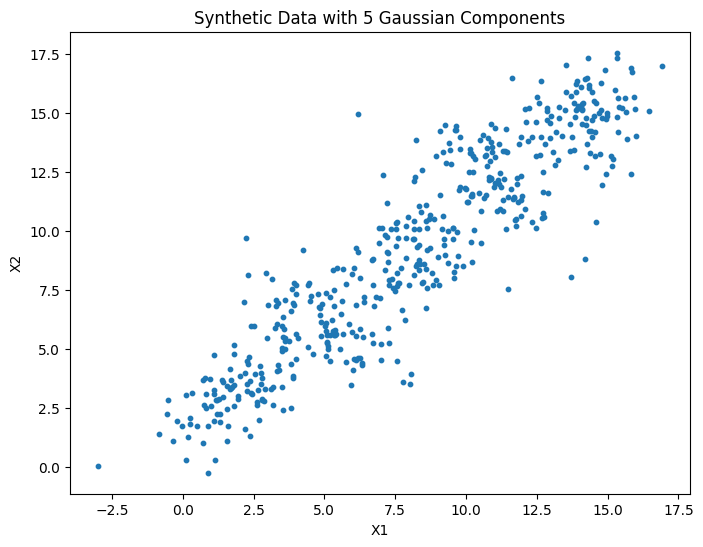

In [16]:
# Plot the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title('Synthetic Data with 5 Gaussian Components')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Plot data with true labels

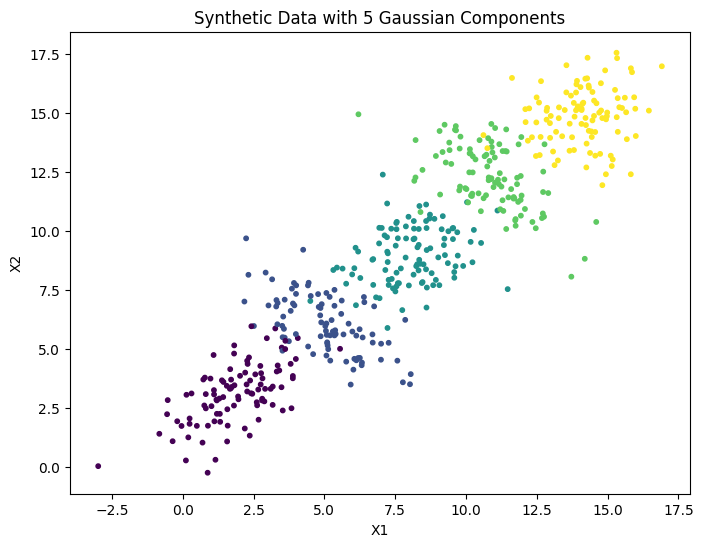

In [18]:
# Plot the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=10, c=comps_)
plt.title('Synthetic Data with 5 Gaussian Components')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Code to fit GMM with EM Algorithm

In [22]:
def initialize_parameters(X, k):
    '''
    Initialize the parameters. Weights are initialized as 1/n_components. Means are selected as a random sample. Covariances are identity.
    '''
    n, d = X.shape
    weights = np.ones(k) / k
    means = X[np.random.choice(n, k, False)]
    covariances = np.array([np.eye(d)] * k)
    return weights, means, covariances

def e_step(X, weights, means, covariances):
    '''
    E-step of the EM algorithm. Here we update the responsibilities and essentially form the Q function. 
    '''
    n, d = X.shape
    k = weights.shape[0]
    responsibilities = np.zeros((n, k))
    
    for i in range(k):
        diff = X - means[i]
        inv_cov = np.linalg.inv(covariances[i])
        norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(np.linalg.det(covariances[i])))
        responsibilities[:, i] = weights[i] * norm_const * np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1))
    
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(X, responsibilities):
    '''
    M-step of the EM algorithm. Here we maximize the Q function which in the case of GMMs has an analytical solution. 
    '''
    n, d = X.shape
    k = responsibilities.shape[1]
    
    weights = responsibilities.sum(axis=0) / n
    means = np.dot(responsibilities.T, X) / responsibilities.sum(axis=0)[:, np.newaxis]
    covariances = np.zeros((k, d, d))
    
    for i in range(k):
        diff = X - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / responsibilities[:, i].sum()
    
    return weights, means, covariances

def log_likelihood(X, weights, means, covariances):
    '''
    This is the GMM log-likelihood used as a metric to monitor the optimization. 
    '''
    n, d = X.shape
    k = weights.shape[0]
    log_likelihood = 0.0
    
    for i in range(k):
        diff = X - means[i]
        inv_cov = np.linalg.inv(covariances[i])
        norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(np.linalg.det(covariances[i])))
        log_likelihood += weights[i] * norm_const * np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1))
    
    return np.sum(np.log(log_likelihood))

def fit_gmm(X, k, max_iter=1000, tol=1e-6):
    '''
    This function fits a GMM using the EM algorithm. 
    '''
    weights, means, covariances = initialize_parameters(X, k)
    log_likelihood_history = []
    
    for step in range(max_iter):
        responsibilities = e_step(X, weights, means, covariances)
        weights, means, covariances = m_step(X, responsibilities)
        log_likelihood_value = log_likelihood(X, weights, means, covariances)
        log_likelihood_history.append(log_likelihood_value)
        
        if len(log_likelihood_history) > 1 and np.abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tol:
            print(f'Algorithm converged within {step+1} iterations.')
            break
    
    return weights, means, covariances, log_likelihood_history

# Fit GMM

In [23]:
weights, means, covariances, log_likelihood_history = fit_gmm(X, 5)

Algorithm converged within 136 iterations.


# Check convergence of log-likelihood

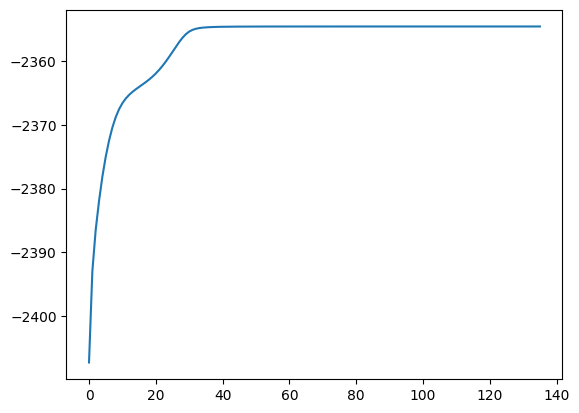

In [24]:
plt.figure()
plt.plot(log_likelihood_history)
plt.show()

# Functions to visualize the GMM in 2D

In [29]:
from scipy.stats import multivariate_normal

def plot_gmm_component_contours(X, weights, means, covariances):
    '''
    Make a plot of the contours of each GMM component in 2D.
    '''
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], s=10, label='Data points')
    
    x = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 100)
    y = np.linspace(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, 100)
    X_mesh, Y_mesh = np.meshgrid(x, y)
    pos = np.dstack((X_mesh, Y_mesh))

    for i in range(len(weights)):
        rv = multivariate_normal(means[i], covariances[i])
        plt.contour(X_mesh, Y_mesh, rv.pdf(pos), levels=10, cmap='viridis')
    
    plt.title('GMM Components Contours')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()

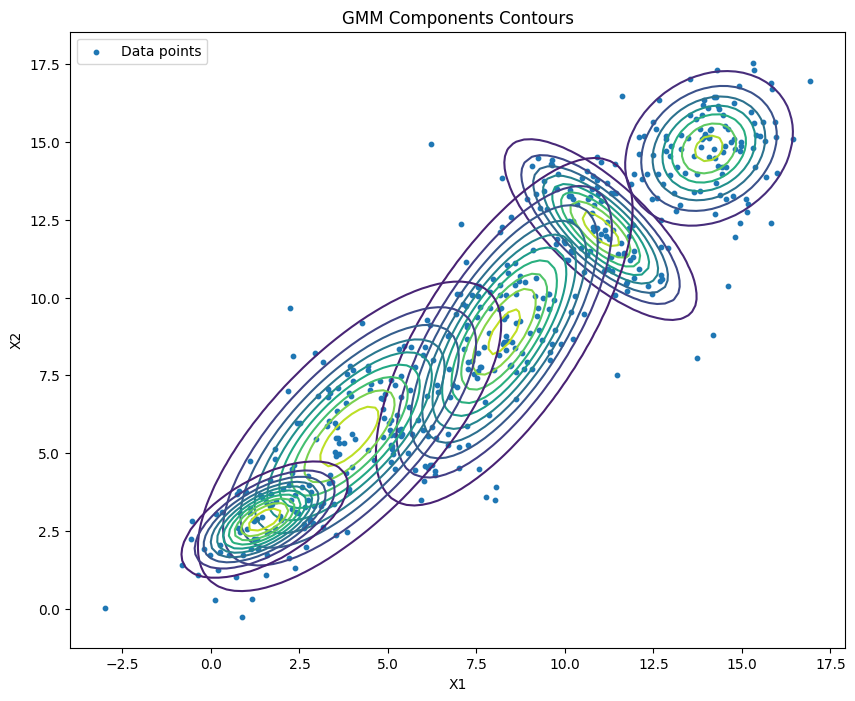

In [30]:
plot_gmm_component_contours(X,weights,means,covariances)

In [31]:
def plot_gmm_density_contours(X, weights, means, covariances):
    '''
    Plot contours of GMM in 2D.
    '''
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], s=10, label='Data points')

    x = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 100)
    y = np.linspace(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, 100)
    X_mesh, Y_mesh = np.meshgrid(x, y)
    pos = np.dstack((X_mesh, Y_mesh))

    total_pdf = np.zeros(pos.shape[:2])

    for i in range(len(weights)):
        rv = multivariate_normal(means[i], covariances[i])
        total_pdf += weights[i] * rv.pdf(pos)

    plt.contour(X_mesh, Y_mesh, total_pdf, levels=10, cmap='viridis')

    plt.title('GMM Estimated Density Contours')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()

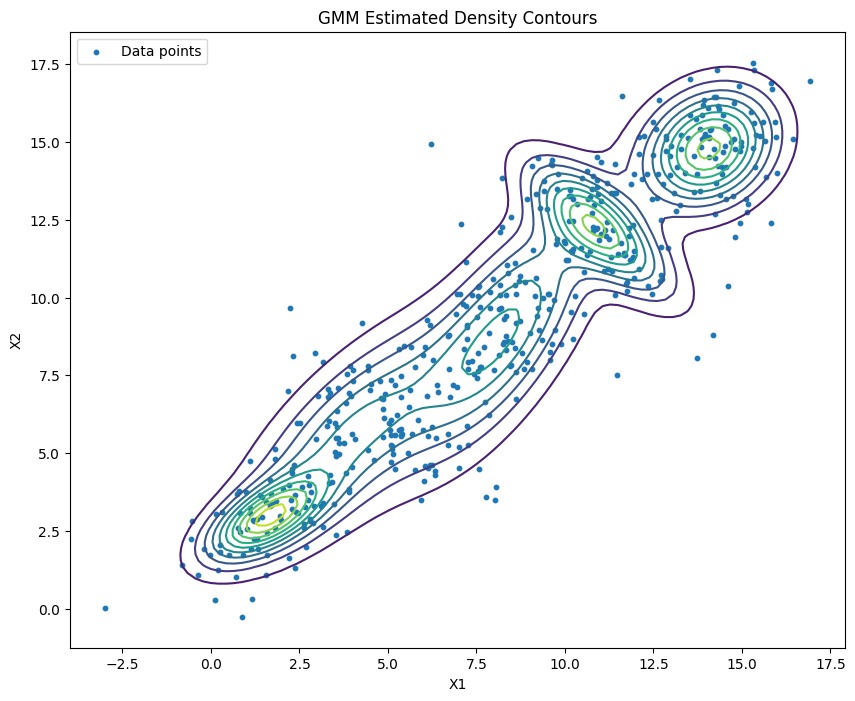

In [32]:
plot_gmm_density_contours(X,weights,means,covariances)

# Object Orientated Implementation

Although this is not required, it is much neater to write code using an object orientated approach. 

In [36]:
class EM_Algorithm:
    def __init__(self, X, k):
        self.X = X
        self.k = k

    def initialize_pars(self):
        X = self.X
        k = self.k
        n, d = X.shape
        self.weights = np.ones(k) / k
        self.means = X[np.random.choice(n, k, False)]
        self.covariances = np.array([np.eye(d)] * k)
        return None

    def e_step(self):
        X = self.X
        weights = self.weights
        covariances = self.covariances
        n, d = X.shape
        k = weights.shape[0]
        responsibilities = np.zeros((n, k))
        
        for i in range(k):
            diff = X - means[i]
            inv_cov = np.linalg.inv(covariances[i])
            norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(np.linalg.det(covariances[i])))
            responsibilities[:, i] = weights[i] * norm_const * np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1))
        
        self.responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
        return None

    def m_step(self):
        responsibilities = self.responsibilities
        X = self.X
        n, d = X.shape
        k = responsibilities.shape[1]
        
        weights = responsibilities.sum(axis=0) / n
        means = np.dot(responsibilities.T, X) / responsibilities.sum(axis=0)[:, np.newaxis]
        covariances = np.zeros((k, d, d))
        
        for i in range(k):
            diff = X - means[i]
            covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / responsibilities[:, i].sum()

        self.weights = weights
        self.means = means
        self.covariances = covariances
        return None

    def log_likelihood(self):
        X = self.X
        weights = self.weights
        means = self.means
        covariances = self.covariances
        n, d = X.shape
        k = weights.shape[0]
        log_likelihood = 0.0
        
        for i in range(k):
            diff = X - means[i]
            inv_cov = np.linalg.inv(covariances[i])
            norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(np.linalg.det(covariances[i])))
            log_likelihood += weights[i] * norm_const * np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1))
        
        return np.sum(np.log(log_likelihood))

    def fit(self, max_iter=1000, tol=1e-6):
        self.initialize_pars()
        log_likelihood_history = []
        
        for step in range(max_iter):
            self.e_step()
            self.m_step()
            log_likelihood_value = self.log_likelihood()
            log_likelihood_history.append(log_likelihood_value)
            
            if len(log_likelihood_history) > 1 and np.abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tol:
                print(f'Algorithm converged within {step+1} iterations.')
                break
        
        return None

## Initialize the class object

In [37]:
em_algorithm = EM_Algorithm(X, k=5)

## Call the `fit` method from the `EM_Algorithm` class

In [38]:
em_algorithm.fit(max_iter=1000, tol=1e-06)

Algorithm converged within 136 iterations.


## Extract results stored as attributes of the class

In [39]:
est_weights = em_algorithm.weights
est_means = em_algorithm.means
est_covs = em_algorithm.covariances
est_responsibilities = em_algorithm.responsibilities

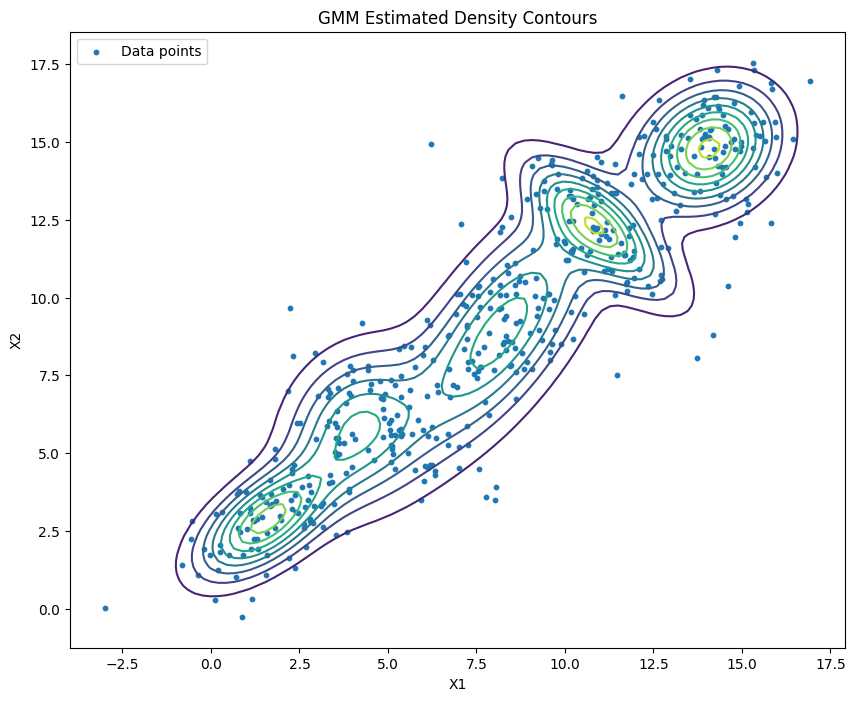

In [40]:
plot_gmm_density_contours(X, est_weights, est_means, est_covs)

## Use estimated responsibilities to cluster

In [42]:
preds = est_responsibilities.argmax(axis=1)

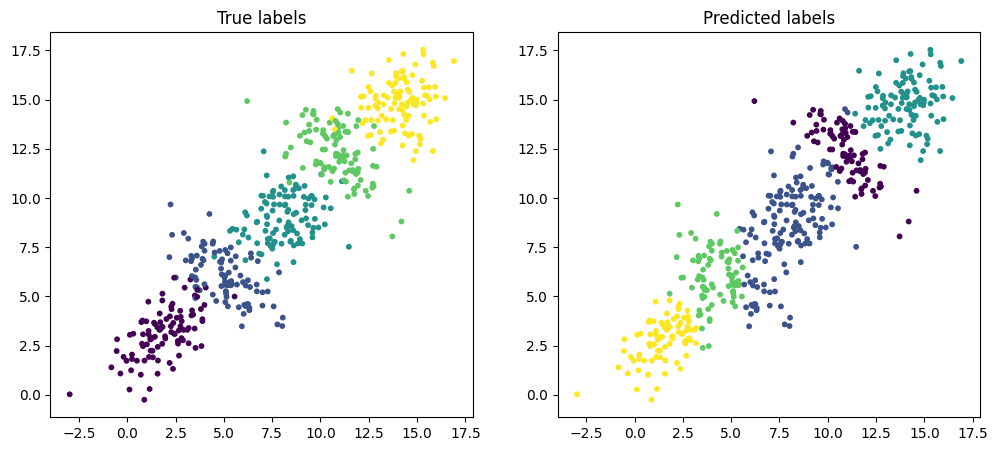

In [47]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(X[:, 0], X[:, 1], s=10, c=comps_)
ax[0].set_title('True labels')
ax[1].scatter(X[:, 0], X[:, 1], s=10, c=preds)
ax[1].set_title('Predicted labels')
plt.show()

# Using `scikit-learn` for EM Algorithm

In [49]:
from sklearn.mixture import GaussianMixture

In [50]:
sklearn_gmm = GaussianMixture(n_components=5, max_iter=1000)

In [51]:
sklearn_gmm.fit(X)

GaussianMixture(max_iter=1000, n_components=5)

In [52]:
sklearn_gmm.weights_

array([0.2084336 , 0.196417  , 0.20649846, 0.19583478, 0.19281616])

In [53]:
sklearn_gmm.means_

array([[14.08142025, 14.82376397],
       [ 1.87876807,  3.10842714],
       [ 8.17862336,  9.0972319 ],
       [10.87989247, 12.25329327],
       [ 5.03497002,  6.09248131]])

In [54]:
sklearn_gmm.covariances_

array([[[ 1.36917472,  0.250293  ],
        [ 0.250293  ,  1.49149635]],

       [[ 1.75476313,  1.05928542],
        [ 1.05928542,  1.63027644]],

       [[ 1.32075496,  0.30665736],
        [ 0.30665736,  1.58252992]],

       [[ 1.64421242, -1.02010357],
        [-1.02010357,  1.84716643]],

       [[ 1.83842141, -0.84647945],
        [-0.84647945,  1.62982654]]])

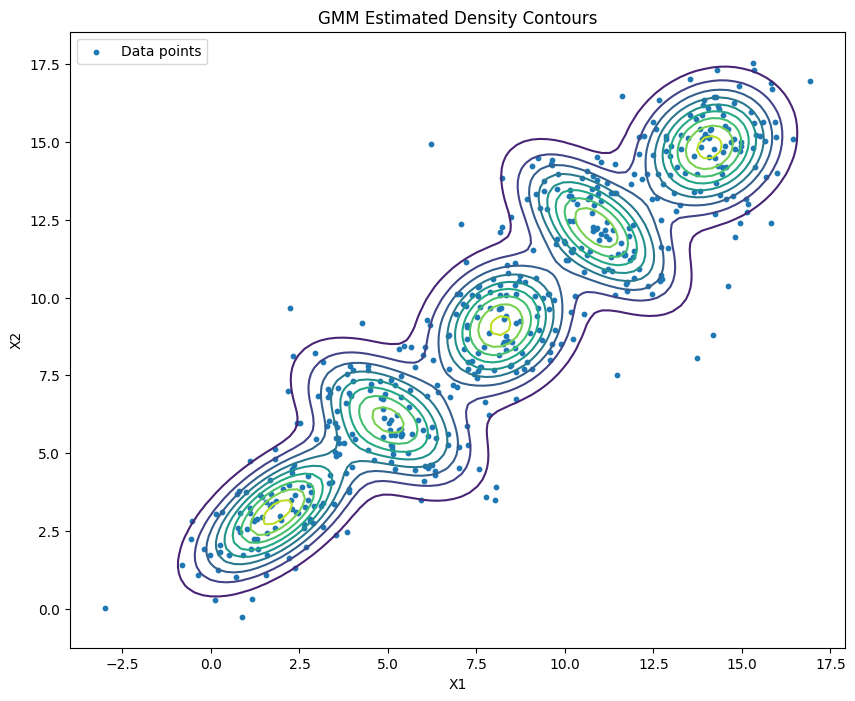

In [55]:
plot_gmm_density_contours(X, sklearn_gmm.weights_, sklearn_gmm.means_, sklearn_gmm.covariances_)

In [56]:
preds = sklearn_gmm.predict(X)

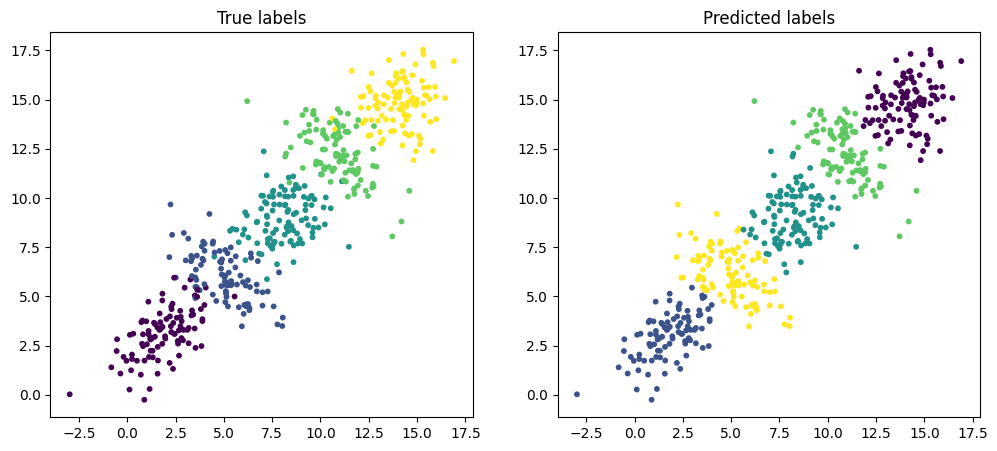

In [57]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(X[:, 0], X[:, 1], s=10, c=comps_)
ax[0].set_title('True labels')
ax[1].scatter(X[:, 0], X[:, 1], s=10, c=preds)
ax[1].set_title('Predicted labels')
plt.show()

# Selecting Number of components

Note that `sklearn` has a `bic` and `aic` method that can be used to select the number of components. One can also use cross-validation to monitor the log-likelihood. 

In [59]:
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

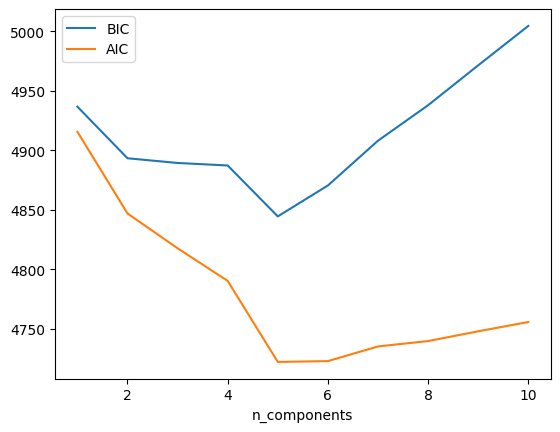

In [60]:
plt.figure()
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

# Complex density estimation

A GMM can be used to estimate very complex densities. The more components in the GMM, the more flexible the model. 

In [61]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(500, noise=.1, random_state=12)

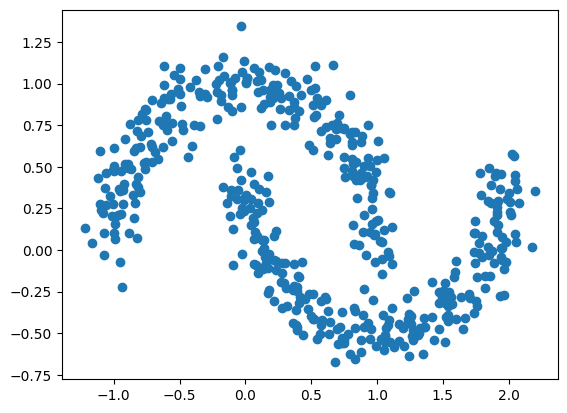

In [62]:
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [63]:
n_components = np.arange(1, 26)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

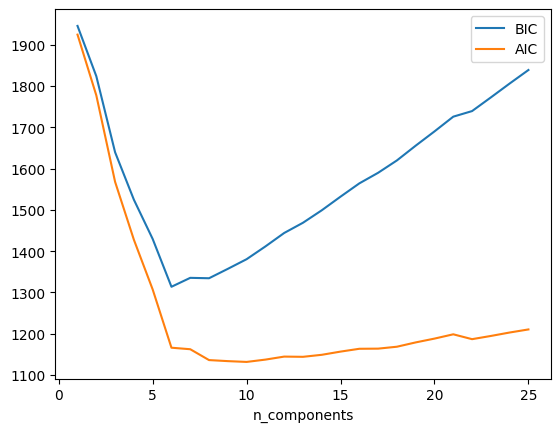

In [64]:
plt.figure()
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

Between 6 and 10 components seem optimal.

In [66]:
my_gmm = GaussianMixture(n_components=8, max_iter=1000).fit(Xmoon)

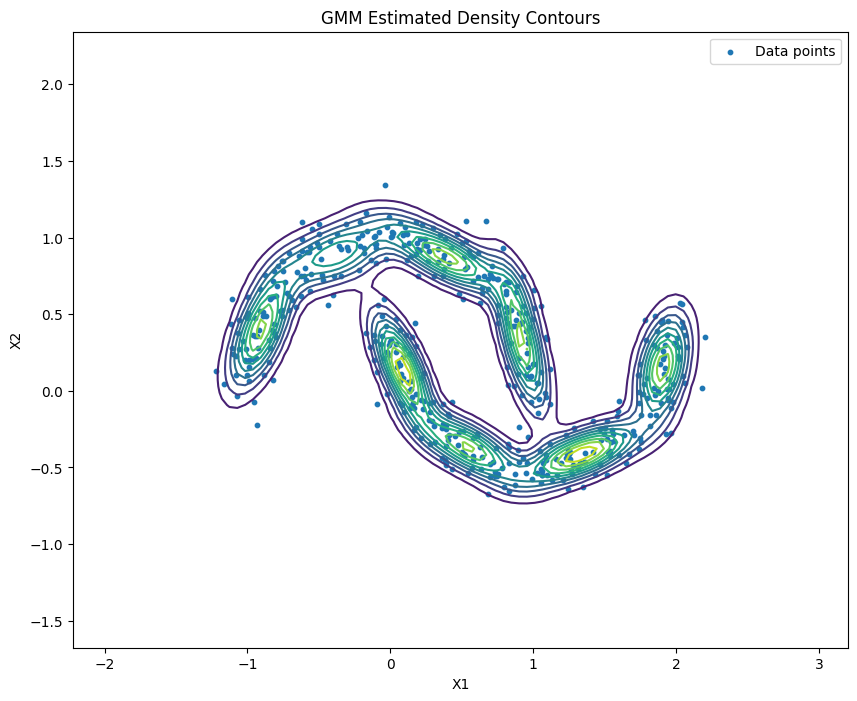

In [68]:
plot_gmm_density_contours(Xmoon, my_gmm.weights_, my_gmm.means_, my_gmm.covariances_)